# Correcting relative hydration free energies using deep neural networks

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Path-variables" data-toc-modified-id="Path-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Path variables</a></span></li><li><span><a href="#Global-variables" data-toc-modified-id="Global-variables-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Global variables</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Model-hyper-parameter-statistics" data-toc-modified-id="Model-hyper-parameter-statistics-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model hyper-parameter statistics</a></span></li><li><span><a href="#Propagation-of-errors" data-toc-modified-id="Propagation-of-errors-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Propagation of errors</a></span></li><li><span><a href="#External-testing" data-toc-modified-id="External-testing-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>External testing</a></span><ul class="toc-item"><li><span><a href="#Load-testing-data" data-toc-modified-id="Load-testing-data-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Load testing data</a></span></li><li><span><a href="#Original-$\Delta-G_{hydr}$" data-toc-modified-id="Original-$\Delta-G_{hydr}$-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Original $\Delta G_{hydr}$</a></span></li><li><span><a href="#Predict-$\Delta-G_{offset}$" data-toc-modified-id="Predict-$\Delta-G_{offset}$-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Predict $\Delta G_{offset}$</a></span></li><li><span><a href="#$\Delta-G_{hydr}$-correction" data-toc-modified-id="$\Delta-G_{hydr}$-correction-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>$\Delta G_{hydr}$ correction</a></span></li></ul></li><li><span><a href="#Removing-outlier" data-toc-modified-id="Removing-outlier-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Removing outlier</a></span></li><li><span><a href="#Recreating-SAMPL4-Figure-1" data-toc-modified-id="Recreating-SAMPL4-Figure-1-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Recreating SAMPL4 Figure 1</a></span></li></ul></div>

## Imports

In [46]:
# General:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import csv
import time
import shutil
import logging
import pickle
from tqdm import tqdm

# Statistics:
import scipy
import statistics
from sklearn.metrics import r2_score

# Tensorflow:
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

# SciKit-Optimise:
from skopt import gp_minimize, dump, load
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# Statistics:
import scipy
from uncertainties import unumpy
import itertools
itertools.imap = lambda *args, **kwargs: list(map(*args, **kwargs))

## Path variables

In [2]:
# Path variables:
path = './'
datasets_dr = '../datasets/'
SDF_dr = datasets_dr + 'sdffiles/'
# output_dr = path + 'output_20_calls/'
# figures_dr = path + 'figures_20_calls/'
output_dr = path + 'output/'
figures_dr = path + 'figures/'
freesolv_loc = datasets_dr + 'freesolv_database.txt'

# clear figures_dr
if os.path.exists(figures_dr):
    shutil.rmtree(figures_dr)
if not os.path.exists(figures_dr):
    os.mkdir(figures_dr)

## Global variables

In [14]:
# Global variables:
model_type = 'DNN'
label_col = 'dGoffset (kcal/mol)'

# DNN global variables
n_calls = 40  # Number of Bayesian optimisation loops for hyperparameter optimisation, 40 is best for convergence, > 60 scales to very expensive
epochs = 200
best_mae = np.inf

# load in data set
dtrain_df = pd.read_hdf(datasets_dr + 'dtrain_data.h5', key='relative')
num_input_nodes = len(dtrain_df.columns) - 1

In [112]:
figsize = [8, 6]
fontsize = 18
markersize = 20
linewidth = 2
dGhydr_xlim = [-25.0, 2.5]
dGhydr_ylim = [-25.0, 2.5]
ddGhydr_xlim = [-30.0, 30.0]
ddGhydr_ylim = [-30.0, 30.0]
colour1 = 'darkgray'
colour2 = 'green'
colour3 = 'lightsteelblue'
colour4 = 'palegreen'

## Load data

In [5]:
# gp_minimize object
search_result = load(output_dr + 'gp_minimize_result.pickle')
# lsit of MAE and associated parameters
mae_logger = pd.read_csv(output_dr + 'DNN_statistics.csv')

/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Model hyper-parameter statistics

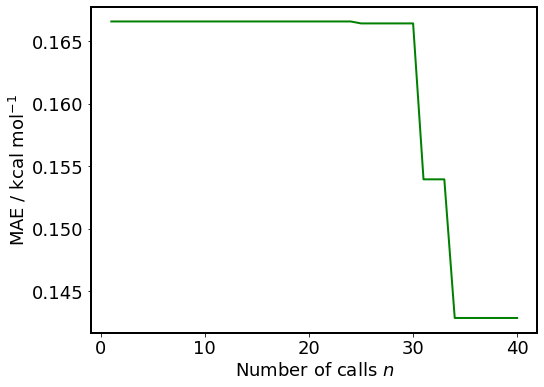

In [15]:
df = pd.read_csv(output_dr + 'DNN_statistics.csv')
x = np.linspace(1, n_calls, n_calls)
y = df.loc[:, 'MAE (kcal/mol)'].cummin()

fig, ax = plt.subplots(figsize=figsize)
ax.set_xlabel('Number of calls $n$', fontsize=fontsize)
ax.set_ylabel('MAE / kcal mol$^{-1}$', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
for axis in ['top','bottom','left','right']: ax.spines[axis].set_linewidth(linewidth)

ax.plot(x, y, color=colour2, linewidth=linewidth)

plt.savefig(figures_dr + 'convergence_plot_2.png')
plt.show()

## Propagation of errors

In [16]:
def calc_mae(x, y):
    """Returns list of mean absolute error between two lists.
    Assumes len(x) == len(y)."""
    ae = [abs(i - j) for i, j in zip(x, y)]
    return sum(ae) / len(ae)

In [17]:
def calc_pearson_r(x, y):
    """
    Calculates Pearson R value.
    Assumes len(x) == len(y).
    Parameters
    ----------
    x: array like of uncertainties.core.Variable
    y: array like of uncertainties.core.Variable
    ----------
    Returns array like of uncertainties.core.Variable
    """
    n = len(x)  # number of samples
    try:
        x_norm = [i.n for i in x]  # x without uncertainty
        y_norm = [i.n for i in y]  # y without uncertainty
    except AttributeError:
        x_norm = x
        y_norm = y
    sum_x = float(sum(x_norm))  # sum of x
    sum_y = float(sum(y_norm))  # sum of y
    sum_x_sq = sum(itertools.imap(lambda x: pow(x, 2), x))  # sum of x**2
    sum_y_sq = sum(itertools.imap(lambda x: pow(x, 2), y))  # sum of y**2
    psum = sum(itertools.imap(lambda x, y: x * y, x, y))  # sum of x*y
    num = psum - (sum_x * sum_y/n)  # Pearson R equation numerator
    den = pow((sum_x_sq - pow(sum_x, 2) / n) * (sum_y_sq - pow(sum_y, 2) / n), 0.5)  # Pearson R formular demoninator
    if den == 0: return 0  # Prevent division by zero
    return num / den

In [19]:
def sum_error(error1, error2):
    """Returns sum propagated error between two int or floats."""
    return (error1 ** 2 + error2 ** 2) ** 0.5

In [20]:
def avg_err(x, y):
    """Returns an averaged error between two lists.
    Assumes len(x) == len(y)."""
    err = [i - j for i, j in zip(x, y)]
    return sum(err) / len(err)

In [21]:
def rmse(x, y):
    """Returns the root means squared error of two lists.
    Assumes len(x) == len(y)"""
    num = sum([(i - j)**2 for i, j in zip(x, y)])
    den = len(x)
    return (num / den)**0.5

In [22]:
def kendall_tau(x, y):
    tau, p_value = scipy.stats.kendalltau(x, y)
    return tau

## External testing

In [113]:
def plot_scatter(calc, exp, title, x_label, y_label, colour):
    """
    Returns and saves linear regression scatter plot.
    Note: takes pre-defined global variables: figsize, linewidth, fontsize, dGhydr_xlim, dGhydr_ylim, markersize, colour1 and colour2,
    and pre-defined functions: calc_mae() and calc_pearson_r().
    Parameters
    ----------
    calc: (DataFrame) calculated data at column index 0 with associated errors at column index 1.
    exp: (DataFrame) experimental data at column index 0 with associated errors at column index 1.
    title: (str) plot title and filename delimitted by underscores. Avoid special characters.
    x_label: (str) x-axis label.
    y_label: (str) y-axis label.
    """
    
    # Unpack data.
    x = calc.iloc[:,0]
    y = exp.iloc[:,0]
    
    # Setup figure.
    fig, ax = plt.subplots(figsize=figsize)
    for axis in ['top','bottom','left','right']: ax.spines[axis].set_linewidth(linewidth)  # Frame line width.
    ax.tick_params(axis='both', which='major', labelsize=fontsize)  # Axis number font size.
    ax.set_xlabel(x_label, fontsize=fontsize)  # X-axis label font size.
    ax.set_ylabel(y_label, fontsize=fontsize)  # Y-axis label font size.
    ax.set_xlim(ddGhydr_xlim)  # X-axis range.
    ax.set_ylim(ddGhydr_ylim)  # Y-axis range.
    
    # Plot scatter.
    ax.scatter(x, y, color=colour, s=markersize)

    # Plot line of best fit.
    ax.plot(np.unique(x),
             np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),
             color='black', linewidth=linewidth)

    # Create uncertainties.core.Variable for statistical analysis
    xu = unumpy.uarray(calc.iloc[:,0], calc.iloc[:,1])
    yu = unumpy.uarray(exp.iloc[:,0], exp.iloc[:,1])
    
    # Calculate mean absolute error.
    mae = calc_mae(xu, yu)
    
    # Calculate Pearson R.
    r_value = calc_pearson_r(xu, yu)

    # Annotate with mean absolute error and Pearson R.
    string = 'MAE = {} {}\nR = {}'.format(mae, 'kcal mol$^{-1}$', r_value).replace('+/-', '$\pm$')
    ax.annotate(string, xy=(0, 1), xytext=(12, -12), va='top',
                 xycoords='axes fraction', textcoords='offset points',
                 size=fontsize)

    # Save figure using the title as filename.
    filename = figures_dr + str(title).lower().replace(' ', '_') + '.png'
    plt.savefig(filename)
    logging.info('Saved {}.'.format(filename))

### Load testing data

In [24]:
freesolv_df = pd.read_csv(freesolv_loc, sep='; ', engine='python').rename(columns={'compound id (and file prefix)': 'ID'})
freesolv_df = freesolv_df.set_index('ID').sort_index()

In [95]:
dtest_X = pd.read_csv(datasets_dr + 'dtest_data.csv', index_col='ID').iloc[:,:-2].sort_index()
dtest_y = pd.read_csv(datasets_dr + 'dtest_data.csv', index_col='ID').iloc[:,-2:].sort_index()
dtest_ID = dtest_y.index

In [80]:
def calc_relative_dataframe(dataframe):

    ddataframe = pd.DataFrame(columns=[dataframe.index.name, dataframe.columns[0], 'uncertainty (kcal/mol)'])
    ddataframe = ddataframe.set_index('ID')
    
    for id1, col in dataframe.iterrows():
        for id2, row in dataframe.iterrows():
            df = pd.concat(
                [pd.DataFrame([col[:-1] - row[:-1]], index=[str(id1) + '~' + str(id2)]),
                 pd.DataFrame({'uncertainty (kcal/mol)': sum_error(col[-1], row[-1])}, index=[str(id1)+'~'+str(id2)])],
                axis=1
            )
            if not id1 == id2:
                ddataframe = ddataframe.append(df, sort=False)
    
    return ddataframe

In [94]:
test_exp = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie',
                           ['experimental value (kcal/mol)', 'experimental uncertainty (kcal/mol)']].sort_index()
test_fep = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie',
                           ['Mobley group calculated value (GAFF) (kcal/mol)', 'calculated uncertainty (kcal/mol)']].sort_index()
dtest_exp = calc_relative_dataframe(test_exp)
dtest_fep = calc_relative_dataframe(test_fep)

### Original $\Delta G_{hydr}$

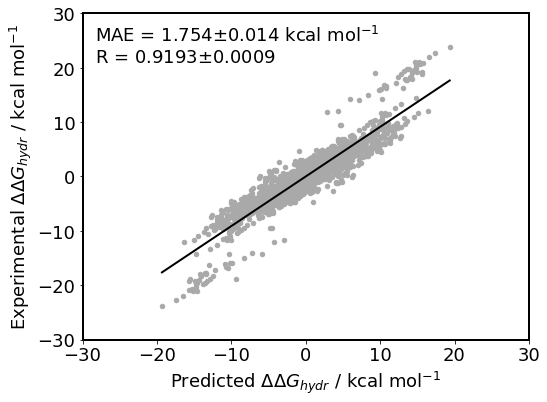

In [114]:
plot_scatter(calc=dtest_fep,
             exp=dtest_exp,
             title='Original test set relative hydraton free energy',
             x_label='Predicted $\Delta \Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta \Delta G_{hydr}$ / kcal mol$^{-1}$',
             colour=colour1)

### Predict $\Delta G_{offset}$

In [102]:
# trained model
model = tf.keras.models.load_model(output_dr + 'ddGhydr_' + model_type + '_model.h5')
# predict
dpredicted_y = model.predict(dtest_X.to_numpy())
dpredicted_y = pd.DataFrame(data={'Average predicted dGhydr (kcal/mol)': [float(x) for x in dpredicted_y],
                                      'Standard deviation (kcal/mol)': np.zeros(len(dpredicted_y))},
                            index=dtest_ID)

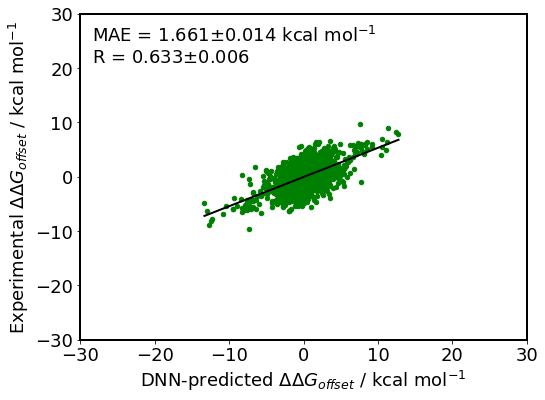

In [115]:
plot_scatter(calc=dpredicted_y,
             exp=dtest_y,
             title='DNN-predicted test set offsets',
             x_label='DNN-predicted $\Delta \Delta G_{offset}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta \Delta G_{offset}$ / kcal mol$^{-1}$',
             colour=colour2)

### $\Delta G_{hydr}$ correction

In [106]:
dtest_corr = pd.DataFrame(data={'FEP+ML dGoffset (kcal/mol)': [fep + offset for fep, offset in zip(dtest_fep.iloc[:,0], dpredicted_y.iloc[:,0])],
                               'uncertainty (kcal/mol)': [sum_error(x, y) for x, y in zip(dpredicted_y.iloc[:,1], dtest_fep.iloc[:,1])]},
                         index=dtest_ID)

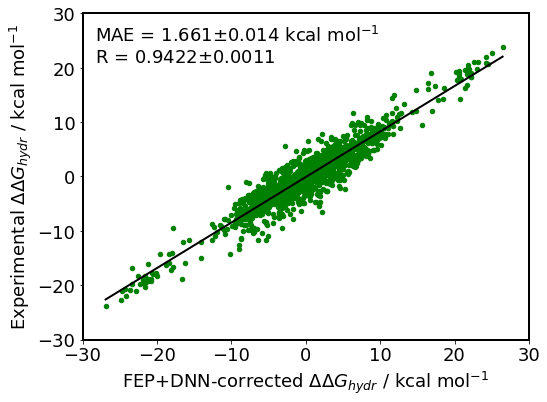

In [116]:
plot_scatter(calc=dtest_corr,
             exp=dtest_exp,
             title='FEP+DNN corrected test set hydraton free energy',
             x_label='FEP+DNN-corrected $\Delta \Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta \Delta G_{hydr}$ / kcal mol$^{-1}$',
             colour=colour2)

In [119]:
def plot_scatter_with_arrows(calc, exp, offsets, corr):
    """
    Returns and saves several overlayed plots:
    1. Uncorrected scatter plot between calculated and experiemntal values.
    2. Corrected scatter plot between corrections and experiemntal values.
    3. Line of best fit for the aforementioned corrected scatter plot.
    4. Arrows in the form of annotations between respective uncorrected and corrected scatter points.
    Note: takes pre-defined global variables: linewidth, fontsize, dGhydr_xlim, dGhydr_ylim, markersize, colour1 and colour2,
    and pre-defined functions: calc_mae() and calc_pearson_r().
    ----------
    Parameters
    ----------
    calc: (DataFrame) calculated data at column index 0 with associated errors at column index 1.
    exp: (DataFrame) experimental data at column index 0 with associated errors at column index 1.
    offsets: (DataFrame) predicted offsets at column index 0 with associated errors at column index 1.
    corr: (DataFrame) corrected calculated data at column index 0 with associated errors at column index 1.
    """
    
    # Unpack data.
    x_fep = calc.iloc[:,0]
    x_ml = corr.iloc[:,0]
    y = exp.iloc[:,0]
    offset = offsets.iloc[:,0]
    
    # Setup figure.
    fig, ax = plt.subplots(figsize=[15,10])
    for axis in ['top','bottom','left','right']: ax.spines[axis].set_linewidth(linewidth)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_xlabel('Predicted $\Delta G_{hydr}$ / kcal mol$^{-1}$', fontsize=fontsize)
    ax.set_ylabel('Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$', fontsize=fontsize)
    ax.set_xlim(ddGhydr_xlim)
    ax.set_ylim(ddGhydr_ylim)
    
    # Plot FEP vs exp and FEP+ML vs exp.
    ax.scatter(x_fep, y, color=colour1, s=markersize, label='FEP')
    ax.scatter(x_ml, y, color=colour2, s=markersize, label='FEP+DNN')
    
    # Plot line of best fit.
    ax.plot(np.unique(x_ml),
         np.poly1d(np.polyfit(x_ml, y, 1))(np.unique(x_ml)),
         color='black', linewidth=linewidth)
    
    # Annotate with arrows.
    for o, f, e in zip(offset, x_fep, y):
        fep_corrected = f + o
        fep_offset = e - f
        fep_corrected_offset = e - fep_corrected
        
        if abs(fep_corrected_offset) <= abs(fep_offset):
            line_color = "green"
        else:
            line_color = "red"
            
        ax.annotate("", xytext=(f, e), xy=(fep_corrected, e), 
                     arrowprops=dict(arrowstyle="->", color=line_color))

    # create uncertainties.core.Variable for statistical analysis
    xu = unumpy.uarray(corr.iloc[:,0], corr.iloc[:,1])
    yu = unumpy.uarray(exp.iloc[:,0], exp.iloc[:,1])
    
    # mean absolute error
    mae = calc_mae(xu, yu)
    
    # Pearson R and R-squared
    r_value = calc_pearson_r(xu, yu)

    # annotate with r-squared and MAE
    string = 'MAE = {} {}\nR = {}'.format(mae, 'kcal mol$^{-1}$', r_value).replace('+/-', '$\pm$')
    ax.annotate(string, xy=(0, 1), xytext=(12, -12), va='top',
                 xycoords='axes fraction', textcoords='offset points',
                 size=fontsize)

    # Create legend.
    plt.legend(loc='lower right', fontsize=fontsize)
    
    # Save figure.
    filename = figures_dr + 'offset_mapping.png'
    plt.savefig(filename)
    logging.info('Saved {}.'.format(filename))

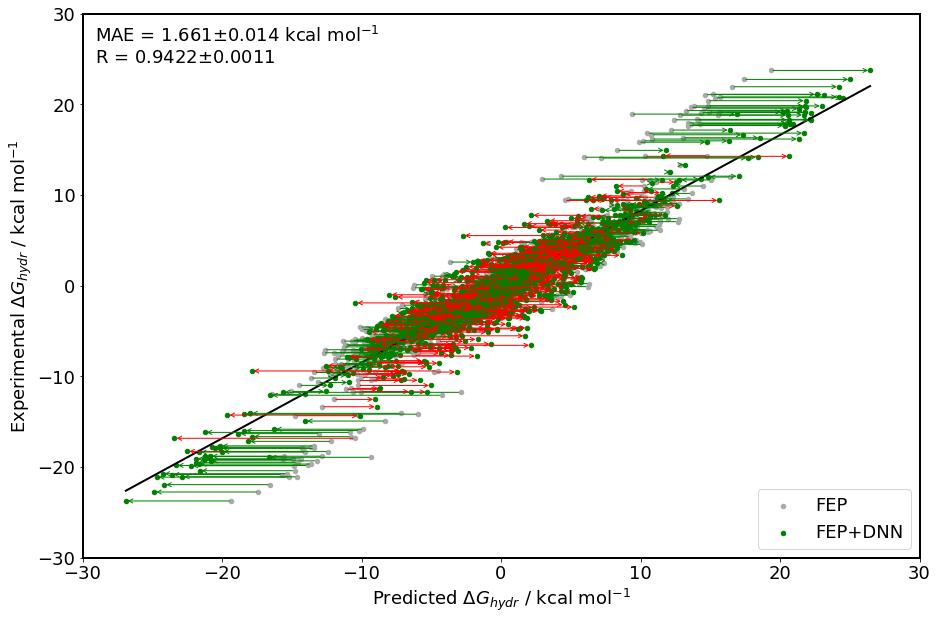

In [120]:
plot_scatter_with_arrows(calc=dtest_fep,
                         exp=dtest_exp,
                         offsets=dpredicted_y,
                         corr=dtest_corr)

## Removing outlier

How does removing mobley_4587267 from the training and testing affect the result?

In [138]:
outlier = 'mobley_4587267'
outlier_lst = [ID for ID in dtest_ID if outlier in ID]

In [146]:
dtest_ID_o = dtest_ID.drop(outlier_lst)

In [152]:
def remove_dindex(dataframe):
    
    df = dataframe
    for outlier in outlier_lst:
        df = df.drop(outlier)
    
    return df

In [161]:
# Remove outlier from all pre-defined DataFrames.
dtest_X_o = remove_dindex(dtest_X)
dtest_y_o = remove_dindex(dtest_y)
dtest_fep_o = remove_dindex(dtest_fep)
dtest_exp_o = remove_dindex(dtest_exp)

# Call pre-loaded trained model.
dpredicted_y_o = model.predict(dtest_X_o.to_numpy())
dpredicted_y_o = pd.DataFrame(data={'Average predicted dGhydr (kcal/mol)': [float(x) for x in dpredicted_y_o],
                                      'Standard deviation (kcal/mol)': np.zeros(len(dpredicted_y_o))},
                            index=dtest_ID_o)

dtest_corr_o = pd.DataFrame(data={'FEP+ML dGoffset (kcal/mol)': [fep + offset for fep, offset in zip(dtest_fep_o.iloc[:,0], dpredicted_y_o.iloc[:,0])],
                               'uncertainty (kcal/mol)': [sum_error(x, y) for x, y in zip(dpredicted_y_o.iloc[:,1], dtest_fep_o.iloc[:,1])]},
                         index=dtest_ID_o)

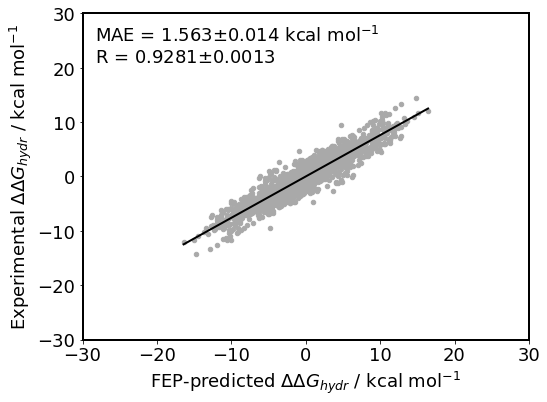

In [163]:
plot_scatter(calc=dtest_fep_o,
             exp=dtest_exp_o,
             title='Original test set hydraton free energy with removed outlier',
             x_label='FEP-predicted $\Delta \Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta \Delta G_{hydr}$ / kcal mol$^{-1}$',
             colour=colour1)

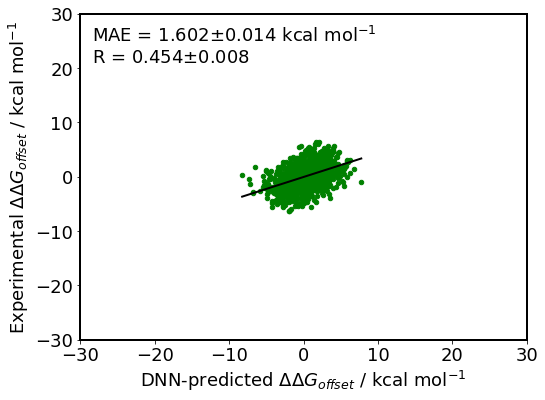

In [164]:
plot_scatter(calc=dpredicted_y_o,
             exp=dtest_y_o,
             title='DNN-predicted test set offsets with removed outlier',
             x_label='DNN-predicted $\Delta \Delta G_{offset}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta \Delta G_{offset}$ / kcal mol$^{-1}$',
             colour=colour2)

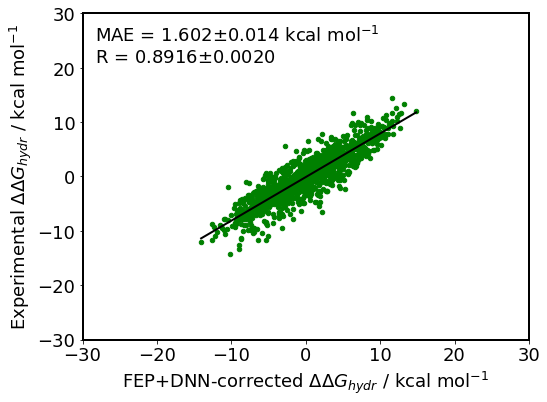

In [165]:
plot_scatter(calc=dtest_corr_o,
             exp=dtest_exp_o,
             title='FEP+DNN corrected test set hydraton free energy with outlier removed',
             x_label='FEP+DNN-corrected $\Delta \Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta \Delta G_{hydr}$ / kcal mol$^{-1}$',
             colour=colour2)

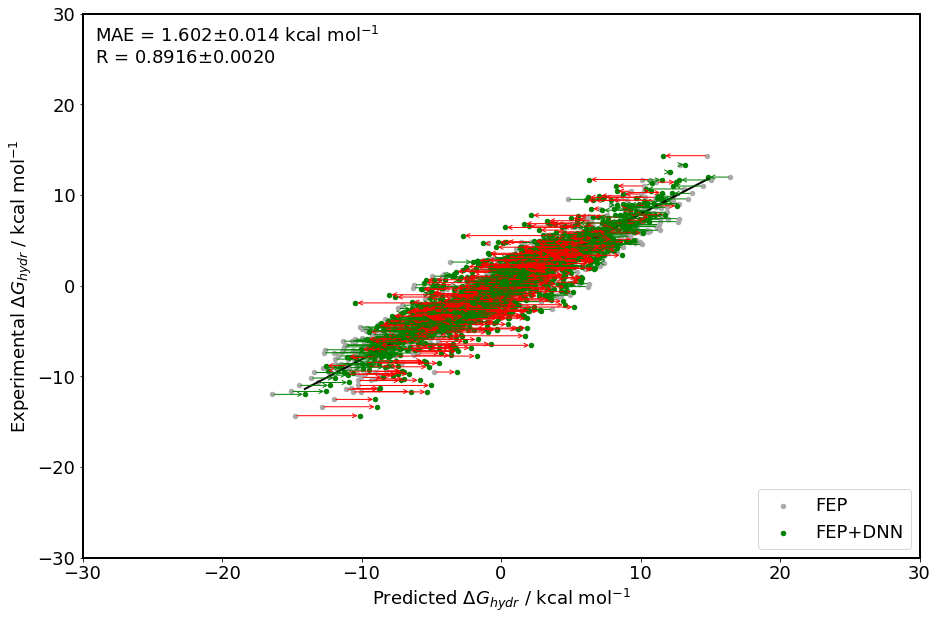

In [166]:
plot_scatter_with_arrows(calc=dtest_fep_o,
                         exp=dtest_exp_o,
                         offsets=dpredicted_y_o,
                         corr=dtest_corr_o)